# BCI

- python C:\Users\MATIAS\Desktop\EEG\Mindjam\CyKit\Py3\CyKIT.py 127.0.0.1 54123 6 pywinusb
- C:\Users\MATIAS\Desktop\EEG\Mindjam\CyKit\Web\CyKIT.html

In [4]:
import os; os.chdir(r'./CyKit/Py3') 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys

In [5]:
#import pyhidapi as hid

In [6]:
import queue
#from cyCrypto.Cipher import AES
from cyCrypto import Random
import threading
import pickle

In [7]:
from ctypes import Structure, c_long, byref
import ctypes

In [8]:
from pyriemann.stats import pairwise_distance
from pyriemann.estimation import Covariances
from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
from collections import deque
from time import sleep
from IPython.display import clear_output
from IPython.display import Audio, display

import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pickle

import jupyter_beeper
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
b = jupyter_beeper.Beeper()

/home/matias/anaconda3/envs/mindjam/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
class POINT(Structure):
    _fields_ = [("x", c_long), ("y", c_long)]

class WinMouse:
    def __init__(self):
        user32 = ctypes.windll.user32
        self.width = user32.GetSystemMetrics(0)
        self.height = user32.GetSystemMetrics(1)

    def click(self, x, y):
        ctypes.windll.user32.SetCursorPos(x, y)
        ctypes.windll.user32.mouse_event(2, 0, 0, 0, 0) # left down
        ctypes.windll.user32.mouse_event(4, 0, 0, 0, 0) # left up

    def move_mouse(self, x, y):
        ctypes.windll.user32.SetCursorPos(x, y)
    
    @staticmethod
    def get_mouse_position():
        pt = POINT()
        windll.user32.GetCursorPos(byref(pt))
        return pt.x, pt.y
        
class BluetoothIO(threading.Thread):
    def __init__(self, eeg_queue, gyro_queue):
        super().__init__()
        self.hid = None
        self.delimiter = ", "
        self.eeg_queue = eeg_queue
        self.gyro_queue = gyro_queue
        devicesUsed = 0
    
        for device in hid.find_all_hid_devices():
            if device.product_name == 'EEG Signals':
                devicesUsed += 1
                self.hid = device
                self.hid.open()
                self.serial_number = device.serial_number
                device.set_raw_data_handler(self.dataHandler)                   
        if devicesUsed == 0:
            os._exit(0)
        sn = self.serial_number
        
        # EPOC+ in 16-bit Mode.
        k = ['\0'] * 16
        k = [sn[-1],sn[-2],sn[-2],sn[-3],sn[-3],sn[-3],sn[-2],sn[-4],sn[-1],sn[-4],sn[-2],sn[-2],sn[-4],sn[-4],sn[-2],sn[-1]]
        
        # EPOC+ in 14-bit Mode.
        #k = [sn[-1],00,sn[-2],21,sn[-3],00,sn[-4],12,sn[-3],00,sn[-2],68,sn[-1],00,sn[-2],88]
        
        self.key = str(''.join(k))
        self.cipher = AES.new(self.key.encode("utf8"), AES.MODE_ECB)

    def dataHandler(self, data):
        join_data = ''.join(map(chr, data[1:]))
        data = self.cipher.decrypt(bytes(join_data,'latin-1')[0:32])
        
        if str(data[1]) == "16":
            self.eeg_queue.append(data)                
        elif str(data[1]) == "32": 
            self.gyro_queue.append(data)
        
    #self.cyIO.sendData(1, str(data[0]) + packet_data)
    #continue
    
class EEG():
    def __init__(self, eeg_queue, gyro_queue):
        super().__init__()
        self.eeg_queue = eeg_queue
        self.gyro_queue = gyro_queue
        self.delimiter = ', '
        
    def convertEPOC_PLUS(self, value_1, value_2):
        edk_value = "%.8f" % (((int(value_1) * .128205128205129) + 4201.02564096001) + ((int(value_2) -128) * 32.82051289))
        return edk_value
       
    def convertEPOC_PLUS_Gyro(self, value_1, value_2): 
        edk_value = "%.8f" % ((8192.0 + (int(value_1) * 1)) + ((int(value_2) - 128) * 64))   
        return edk_value
    
    def get_gyro(self, n):
        buffer = []
        c = 0 
        while c < n:
            try:
                data = self.gyro_queue.popleft()
            except IndexError:
                sleep(0.001)
                continue
            try:
                packet_data = ""
                for i in range(2,16,2):
                    packet_data = packet_data + str(self.convertEPOC_PLUS_Gyro(str(data[i]), str(data[i+1]))) + self.delimiter

                for i in range(18,len(data),2):
                    packet_data = packet_data + str(self.convertEPOC_PLUS_Gyro(str(data[i]), str(data[i+1]))) + self.delimiter

                packet_data = packet_data[:-len(self.delimiter)]
                buffer.append([float(x) for x in packet_data.split(', ')])                
            except Exception as exception2:
                print(str(exception2))
            c += 1
        return np.array(buffer)

    def get_data(self, n):
        buffer = []
        c = 0
        while c < n:
            try:
                data = self.eeg_queue.popleft()
            except IndexError:
                sleep(0.001)
                continue
            try:
                packet_data = ""
                for i in range(2,16,2):
                    packet_data = packet_data + str(self.convertEPOC_PLUS(str(data[i]), str(data[i+1]))) + self.delimiter
                for i in range(18,len(data),2):
                    packet_data = packet_data + str(self.convertEPOC_PLUS(str(data[i]), str(data[i+1]))) + self.delimiter

                packet_data = packet_data[:-len(self.delimiter)]
                buffer.append([float(x) for x in packet_data.split(', ')])                
            except Exception as exception2:
                print(str(exception2))
            c += 1
        return np.array(buffer)
    
def butter_bandpass(lowcut, highcut, fs, order=5):
    #https://github.com/faturita/python-nerv/blob/master/OfflineFeatureAnalysis3.py
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plot_welch(t, canal = 0):
    f, pxx = scipy.signal.welch(t[:,canal], fs = 44100)
    plt.plot(f, pxx)
    plt.xlim(0, 10000)
    plt.xlabel('Frecuencias')

def plot_multiple(w, fs = 256):
    '''Plotea primero la onda en dominio de tiempo, luego el espectro (FFT) y luego el espectrograma'''
    
    #Creo el espacio para plotear, una "figura" vacia
    plt.figure(figsize=(15,15))

    #Dividido en 3 filas y 1 columna, ploteo la onda en el 1er espacio
    plt.subplot(3, 1, 1)
    plt.plot(w)
    
    #Pongo titulo al eje y
    plt.ylabel('Amplitude')
    #Grilla de fondo
    plt.grid()
    
    #FFT
    #n = len(w) = duración * framerate
    n = len(w)
    Y = np.fft.rfft(w) / n 
    freqs = np.fft.fftfreq(n, d= 1/44100)
    
    #Plot FFT
    plt.subplot(3, 1, 2)
    #Ploteo las frecuencias positivas y sus valores, con un color RGBA
    plt.plot(freqs[:10000], abs(Y[:10000]), c = [0.9, 0.2, 0.1, 0.8])
    plt.xlabel('Freq (Hz)')
    
    #Marco en el eje X ciertos valores incluyendo la frecuencia de máximo valor
    plt.xticks(np.sort(np.append(freqs[:10000:1000], freqs[np.argmax(abs(Y[:10000]))])), rotation = 60)
    plt.ylabel('|Y(freq)|')

    #Espectrograma
    plt.subplot(3, 1, 3)
    Pxx, freqs, bins, im = plt.specgram(w, Fs=fs, noverlap=10, cmap= 'coolwarm')
    plt.ylim(0, 8000)
    plt.ylabel('Freq')
    plt.xlabel('Time')
    plt.show()
    
def do_fft(data, fs = 256):
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    return eeg_band_fft
        
def plot_bands(eeg_bands):
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_bands[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude") 

In [10]:
# vamos a recolectar 20 datos de 2 segundos para cada acción

acciones = 2
s = 2
n = 120
electrodos = 'F3 FC5 AF3 F7 T7 P7 O1 O2 P8 T8 F8 AF4 FC6 F4'.split()
muestreo = 128
n_paquetes = s * muestreo

<img src="https://www.researchgate.net/publication/329568433/figure/fig3/AS:702680376827906@1544543465572/The-electrode-locations-of-the-14-channel-Emotiv-EEG-headset.ppm" width="300"/>

In [11]:
from scipy.fftpack import fft
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta
from scipy.signal import butter, lfilter

from pyriemann.estimation import XdawnCovariances, Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix
from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances


from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from vecstack import stacking, StackingTransformer

In [13]:
#with open('X.pkl', 'wb') as f:
#    pickle.dump(X, f)
with open('X.pkl', 'rb') as f:
    X = pickle.load(f)

In [14]:
r = np.random.permutation(np.arange(0, len(X)))
X = np.array(X)[r]
y = np.concatenate([np.zeros(n), np.ones(n)])[r]

In [15]:
for i in range(X.shape[2]):
    X[:, i] = X[:, i] - X[:, i].mean()
#    X[:, i] = butter_bandpass_filter(X[:, i], 8.0, 15.0, muestreo, order=4)

In [16]:
#(trials, channels, samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
X_train.shape, X_test.shape

((192, 256, 14), (48, 256, 14))

In [17]:
#EXPLOTA LA PC
#https://github.com/vlawhern/arl-eegmodels/blob/master/examples/ERP.py
#from EEGModels import EEGNet
#from keras.utils import to_categorical
#y_binary = to_categorical(y_train)
#predicted = model.predict(...)
#https://github.com/vlawhern/arl-eegmodels
#model = EEGNet(2, Chans=14, Samples=256)
#model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
#fittedModel = model.fit(X_train.transpose(0,2,1)[:, np.newaxis,:,  :, ], y_binary)

In [18]:
n_components = 5
tran = make_pipeline(Covariances(), 
                    XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    )

In [19]:
tran.fit(X_train, y_train)
X_train = tran.transform(X_train)
X_test = tran.transform(X_test)

In [20]:
models = [
        ('lr', LogisticRegression()),
        ('knn', KNeighborsClassifier(n_neighbors=15)),
        ('rf', RandomForestClassifier()), 
        ('xgb', XGBClassifier(max_depth=15, n_estimators=200)),
        ('gbm', LGBMClassifier()), 
        #('gp', GaussianProcessClassifier()), 
        ('gnb', GaussianNB()),
        ]

In [21]:
probs = []
for i in range(len(models)):
    model = models[i][1]
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    class_balance = np.mean(y_test == y_test[0])
    class_balance = max(class_balance, 1. - class_balance)
    score = cross_val_score(model, tran.transform(X), y, cv=5)
    print(f"{models[i][0]}: Accuracy: {np.mean(preds == y_test):.2f} ({class_balance:.2f} chance) | Cross val acc: {np.mean(score):.2f}")
    probs.append(model.predict_proba(X_test)[:,0])

lr: Accuracy: 0.83 (0.50 chance) | Cross val acc: 0.95
knn: Accuracy: 0.79 (0.50 chance) | Cross val acc: 0.92
rf: Accuracy: 0.79 (0.50 chance) | Cross val acc: 0.89
xgb: Accuracy: 0.92 (0.50 chance) | Cross val acc: 0.96
gbm: Accuracy: 0.92 (0.50 chance) | Cross val acc: 0.95
gnb: Accuracy: 0.85 (0.50 chance) | Cross val acc: 0.95


In [22]:
probs_df = pd.DataFrame(probs).T
probs_df.columns = [n[0] for n in models]

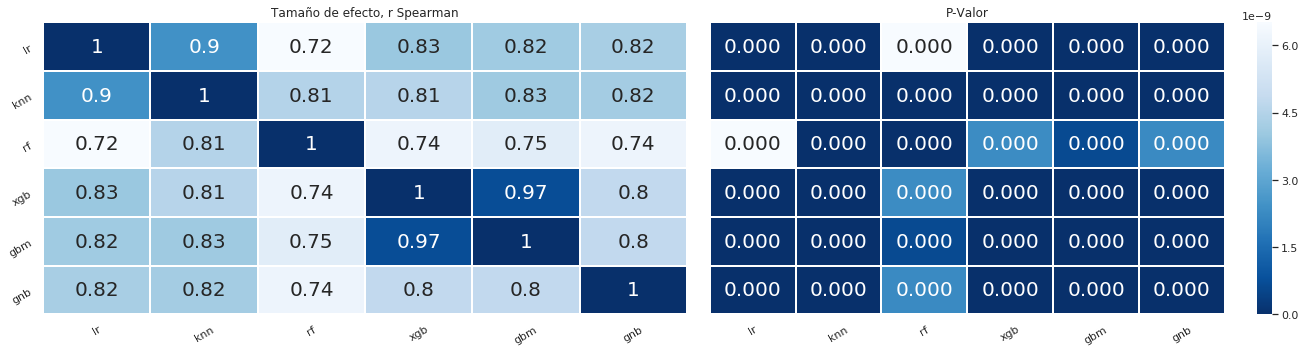

In [23]:
from scipy.stats import spearmanr
cols = probs_df.columns
corrs, ps = spearmanr(probs_df.values)

fig, ax = plt.subplots(1,2,figsize=(19,5))

sns.heatmap(corrs, cmap='Blues', ax=ax[0], cbar=False, annot=True, linewidths=1, annot_kws={"size": 20})
ax[0].set_title('Tamaño de efecto, r Spearman')
ax[0].set_yticklabels(cols, rotation=30)
ax[0].set_xticklabels(cols, rotation=30)

sns.heatmap(ps, cmap='Blues_r', ax=ax[1], annot=True, linewidths=1, fmt='.3f', annot_kws={"size": 20});
ax[1].set_title('P-Valor');
ax[1].set_yticklabels([])
ax[1].set_xticklabels(cols, rotation=30)

plt.tight_layout()

In [24]:
stack = StackingTransformer(models, regression=False, verbose=0, n_folds=5, random_state=0)
stack = stack.fit(X_train, y_train)

In [25]:
S_train = stack.transform(X_train)
S_test = stack.transform(X_test)

In [26]:
final = LogisticRegression()
final = final.fit(S_train, y_train)
preds = final.predict(S_test)

In [27]:
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
score = cross_val_score(final, tran.transform(X), y, cv=5)
print(f"Stacking accuracy: {np.mean(preds == y_test):.2f} ({class_balance:.2f} chance) | Cross val acc: {np.mean(score):.2f}")    

Stacking accuracy: 0.92 (0.50 chance) | Cross val acc: 0.95


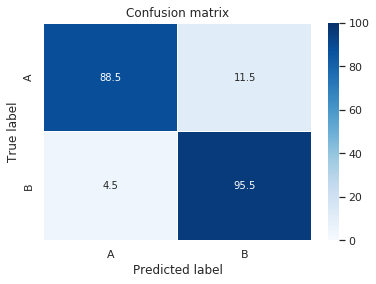

In [28]:
plot_confusion_matrix(preds, y_test, ['A', 'B']);

In [ ]:
t = 100
step = 20
mouse.move_mouse(w//2, h//2)
for n in range(t):
    x, y = mouse.get_mouse_position()
    
    dato = eeg.get_data(muestreo * s)
    prob = clasificador.predict_proba(np.array([dato]))[0][0]
        
    if prob > 0.9:
        print(f'*'*10)
        print(f' Acción 1')
        print(f'*'*10)
        mouse.move_mouse(x, y+step)
        b.beep(frequency=880, secs=0.25, blocking=True)
    
    elif prob < 0.1:
        print(f'*'*10)
        print(f' Acción 2')
        print(f'*'*10)
        mouse.move_mouse(x, y-step)        
        b.beep(frequency=440, secs=0.25, blocking=True)
    
    if n % 20 == 0:
        mouse.move_mouse(w//2, h//2)
    clear_output()  
    
    print('\n')
    sleep(1)

In [29]:
# plot

In [31]:
arr = X[:,0,0]
arr.shape

(240,)